In [956]:
import numpy as np 
import pandas as pd

import os
dir_black = os.path.join('Soil types/Black Soil')
dir_Cinder = os.path.join('Soil types/Cinder Soil')
dir_Laterite = os.path.join('Soil types/Laterite Soil')
dir_peat = os.path.join('Soil types/Peat Soil')
dir_yellow = os.path.join('Soil types/Yellow Soil')
        

In [957]:
import tensorflow as tf
from tensorflow import keras
from  tensorflow.keras import models, layers

In [958]:
image_size = 220
batch_size = 10


target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

In this, the flow_from_directory method automatically scans through all the sub-directories and sources the images along with their appropriate labels.

In [959]:
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    "Soil types",
    shuffle=True,
    image_size=target_size,
    batch_size=batch_size
)

Found 156 files belonging to 5 classes.


In [960]:
len(train_generator)

16

In [961]:
for image_batch, label_batch in train_generator.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(10, 220, 220, 3)
[1 1 1 4 4 1 0 1 0 4]


In [962]:
import matplotlib.pyplot as plt

In [963]:
class_names = train_generator.class_names
class_names

['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']

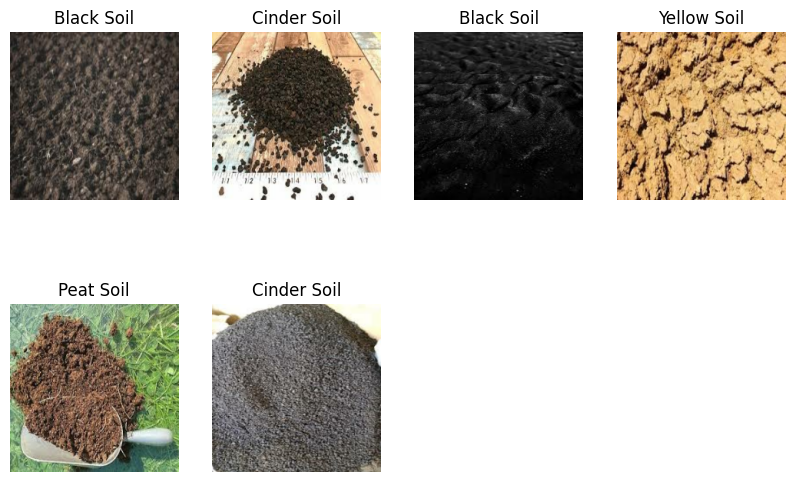

In [964]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_generator.take(1):
    for i in range(6):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i+1].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i+1]])
        plt.axis("off")

In [965]:
train_size = 0.8
len(train_generator)*train_size

12.8

In [966]:
train_ds = train_generator.take(12)
len(train_ds)

12

In [967]:
test_ds = train_generator.skip(12)
len(test_ds)

4

In [968]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [969]:
test_ds = test_ds.skip(2)
len(test_ds)

2

In [970]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [971]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(train_generator)

In [972]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [973]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0/255)
])

In [974]:
data_augmentation = tf.keras.Sequential({
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3)
})

In [975]:
input_shape = (batch_size, image_size, image_size, 3)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

In [976]:
model.summary()

Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_94 (Sequential)      │ (10, 220, 220, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_95 (Sequential)      │ (10, 220, 220, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_266 (Conv2D)             │ (10, 218, 218, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_266               │ (10, 109, 109, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_267 (Conv2D)             │ (10, 107, 107, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_267               │ (10, 53, 53, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_268 (Conv2D)             │ (10, 51, 51, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_268               │ (10, 25, 25, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_269 (Conv2D)             │ (10, 23, 23, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_269               │ (10, 11, 11, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_270 (Conv2D)             │ (10, 9, 9, 64)         │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_270               │ (10, 4, 4, 64)         │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_271 (Conv2D)             │ (10, 2, 2, 32)         │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_271               │ (10, 1, 1, 32)         │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (10, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (10, 64)               │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (10, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,197 (953.89 KB)

 Trainable params: 244,197 (953.89 KB)

 Non-trainable params: 0 (0.00 B)

In [977]:
# from tensorflow.keras.optimizers import RMSprop

# model.compile(loss='categorical_crossentropy',
#               optimizer=RMSprop(learning_rate=0.001),
#               metrics=['accuracy'])

In [978]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [979]:
total_sample = train_generator
n_epochs = 100

In [980]:
history = model.fit(
    train_ds,
    epochs=n_epochs,
    batch_size = batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - accuracy: 0.2203 - loss: 1.6161 - val_accuracy: 0.4000 - val_loss: 1.5889
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - accuracy: 0.1889 - loss: 1.6026 - val_accuracy: 0.4000 - val_loss: 1.4847
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.2431 - loss: 1.5484 - val_accuracy: 0.6000 - val_loss: 1.1621
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - accuracy: 0.3713 - loss: 1.4988 - val_accuracy: 0.8000 - val_loss: 1.1737
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 461ms/step - accuracy: 0.3871 - loss: 1.3472 - val_accuracy: 0.7000 - val_loss: 1.0399
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step - accuracy: 0.4650 - loss: 1.1978 - val_accuracy: 0.4000 - val_loss: 1.0601
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step - accuracy: 0.3334 - loss: 1.0990 - val_accuracy: 0.6000 - val_loss: 0.8930
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 434ms/step - accuracy: 0.4198 - loss: 1.0364 - val_acc

In [981]:
# history = model.fit(
#         train_generator, 
#         steps_per_epoch = int(total_sample/batch_size),  
#         epochs = n_epochs,
#         verbose = 1)

In [982]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9542 - loss: 0.1456


In [983]:
scores

[0.17957477271556854, 0.9333333373069763]

In [984]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and Validation Accuracy')

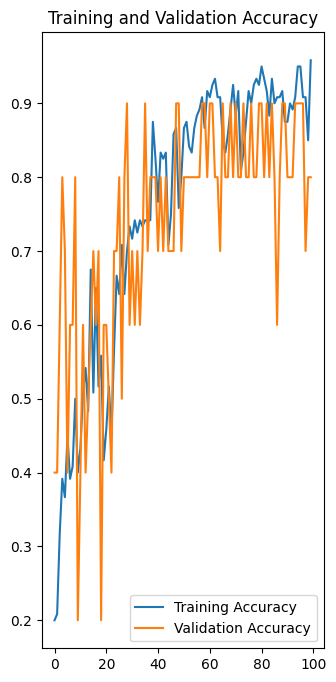

In [985]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(n_epochs), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

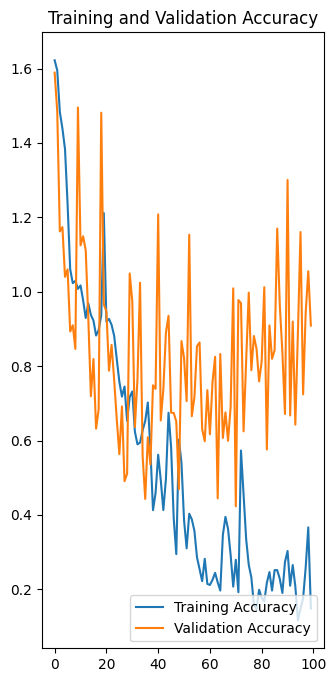

In [986]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), history.history['loss'], label='Training Accuracy')
plt.plot(range(n_epochs), history.history['val_loss'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

First image to predict:
Actual label:  Black Soil
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
Predicted label:  Black Soil


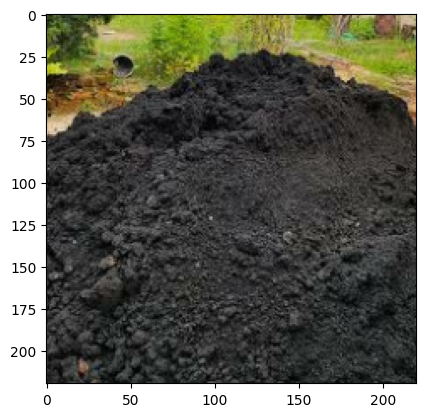

In [987]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    print("Actual label: ",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
# model_version = 7
# model.save(f"./models/version{model_version}.keras")